In [23]:
import vespa
import h5py
import numpy as np
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt
%matplotlib notebook

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from EBLSST import BreivikGalaxy, EclipsingBinary

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get the field centers and number of observations from OpSim

In [3]:
#https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335
#http://ops2.lsst.org/docs/current/architecture.html
db = sqlite3.connect('/Users/ageller/WORK/LSST/onGitHub/EBLSST/db/minion_1016_sqlite.db')
cursor = db.cursor()
cursor.execute("SELECT fieldid, fieldra, fielddec, fieldFov FROM field")
#cursor.execute("SELECT fielddec FROM field")
fieldCursor = np.array(cursor.fetchall()) 

cursor.execute("SELECT fieldid, expDate, filter FROM summary")
summaryCursor = np.array(cursor.fetchall()) 
FieldID = summaryCursor[:,0].astype('int')
date = summaryCursor[:,1].astype('float')

fID = np.array([])
RA = np.array([])
Dec = np.array([])
nobs = np.array([])
for x in fieldCursor:
    inS = np.where(FieldID == int(x[0]))[0]
    nobs = np.append(nobs, len(inS))
    fID = np.append(fID, x[0])
    RA = np.append(RA, x[1])
    Dec = np.append(Dec, x[2])
    
    print(x[0], x[1], x[2],len(inS))


1.0 0.0 -90.0 180
2.0 180.0 -87.5685577392578 180
3.0 324.000427246094 -87.5685501098633 180
4.0 35.9995727539062 -87.5685501098633 180
5.0 252.001098632812 -87.5685501098633 180
6.0 107.998893737793 -87.5685501098633 180
7.0 215.999816894531 -85.2729110717773 180
8.0 144.000183105469 -85.2729110717773 180
9.0 0.0 -85.2728958129883 180
10.0 288.000518798828 -85.2728500366211 180
11.0 71.9994888305664 -85.2728500366211 180
12.0 323.999816894531 -84.7350769042969 180
13.0 36.0001945495605 -84.7350769042969 180
14.0 180.0 -84.7350769042969 180
15.0 251.999847412109 -84.7350616455078 180
16.0 108.000152587891 -84.7350616455078 180
17.0 203.144515991211 -82.7987442016602 180
18.0 156.855484008789 -82.7987442016602 180
19.0 275.144805908203 -82.7987442016602 180
20.0 84.8551864624023 -82.7987442016602 180
21.0 347.144348144531 -82.7987289428711 180
22.0 12.8556642532349 -82.7987289428711 180
23.0 228.855392456055 -82.7987213134766 180
24.0 131.144607543945 -82.7987213134766 180
25.0 300.8556

231.0 223.82585144043 -65.9281005859375 180
232.0 136.17414855957 -65.9281005859375 180
233.0 352.174194335938 -65.928092956543 180
234.0 7.82579898834229 -65.928092956543 180
235.0 280.174194335938 -65.9280853271484 180
236.0 79.8258056640625 -65.9280853271484 180
237.0 272.520355224609 -65.4998168945312 180
238.0 87.4796447753906 -65.4998168945312 180
239.0 231.479629516602 -65.4998016357422 180
240.0 128.520370483398 -65.4998016357422 180
241.0 200.520385742188 -65.4998016357422 180
242.0 159.479614257812 -65.4998016357422 180
243.0 303.479705810547 -65.4997787475586 180
244.0 56.5203056335449 -65.4997787475586 180
245.0 344.520355224609 -65.4997711181641 180
246.0 15.4796476364136 -65.4997711181641 180
247.0 252.000061035156 -65.3223648071289 180
248.0 107.999938964844 -65.3223648071289 180
249.0 324.0 -65.3223342895508 180
250.0 36.0000114440918 -65.3223342895508 180
251.0 180.0 -65.3223266601562 180
252.0 193.196441650391 -64.7826232910156 180
253.0 166.803558349609 -64.782623291

469.0 184.907806396484 -55.3629531860352 902
470.0 175.092193603516 -55.3629531860352 907
471.0 256.907775878906 -55.3629493713379 900
472.0 103.092224121094 -55.3629493713379 919
473.0 328.907806396484 -55.3629264831543 911
474.0 31.0921897888184 -55.3629264831543 918
475.0 247.092208862305 -55.3629264831543 180
476.0 112.907783508301 -55.3629264831543 920
477.0 232.303146362305 -55.2214508056641 180
478.0 127.696846008301 -55.2214508056641 920
479.0 304.303161621094 -55.2214088439941 902
480.0 55.6968269348145 -55.2214088439941 920
481.0 343.696899414062 -55.221378326416 913
482.0 16.3031120300293 -55.221378326416 918
483.0 199.696853637695 -55.221378326416 898
484.0 160.303146362305 -55.221378326416 912
485.0 271.696899414062 -55.2213745117188 899
486.0 88.3031005859375 -55.2213745117188 917
487.0 237.524291992188 -54.5432052612305 180
488.0 122.475708007812 -54.5432052612305 921
489.0 194.47575378418 -54.5432052612305 899
490.0 165.52424621582 -54.5432052612305 911
491.0 309.524353

698.0 56.6593170166016 -47.4244766235352 920
699.0 200.659317016602 -47.4244728088379 896
700.0 159.340682983398 -47.4244728088379 911
701.0 272.659362792969 -47.4244613647461 902
702.0 87.3406448364258 -47.4244613647461 919
703.0 231.340713500977 -47.4244499206543 897
704.0 128.659286499023 -47.4244499206543 919
705.0 344.659301757812 -47.4244422912598 916
706.0 15.3406991958618 -47.4244422912598 919
707.0 184.112655639648 -46.9632415771484 900
708.0 175.887344360352 -46.9632415771484 905
709.0 256.112701416016 -46.9631881713867 180
710.0 103.887298583984 -46.9631881713867 918
711.0 247.887420654297 -46.9631652832031 180
712.0 112.112586975098 -46.9631652832031 920
713.0 319.887390136719 -46.9631576538086 909
714.0 40.1126136779785 -46.9631576538086 920
715.0 328.112609863281 -46.9631500244141 909
716.0 31.8873805999756 -46.9631500244141 920
717.0 340.364410400391 -46.8794555664062 911
718.0 19.6355953216553 -46.8794555664062 921
719.0 307.635559082031 -46.879451751709 903
720.0 52.36

919.0 96.9651870727539 -40.5505676269531 918
920.0 335.034881591797 -40.5505485534668 911
921.0 24.9651165008545 -40.5505485534668 919
922.0 251.999984741211 -40.1036949157715 180
923.0 108.000007629395 -40.1036949157715 917
924.0 324.0 -40.1036911010742 909
925.0 35.9999847412109 -40.1036911010742 919
926.0 180.0 -40.1036911010742 900
927.0 0.0 -40.0516777038574 919
928.0 216.000045776367 -40.0516777038574 892
929.0 143.999954223633 -40.0516777038574 917
930.0 288.000030517578 -40.0516548156738 902
931.0 71.9999694824219 -40.0516548156738 917
932.0 291.709136962891 -40.0062255859375 903
933.0 68.2908782958984 -40.0062255859375 918
934.0 212.290939331055 -40.0061836242676 891
935.0 147.709060668945 -40.0061836242676 917
936.0 219.709121704102 -40.0061721801758 894
937.0 140.290878295898 -40.0061721801758 917
938.0 284.290893554688 -40.0061721801758 900
939.0 75.709114074707 -40.0061721801758 917
940.0 356.290863037109 -40.0061569213867 917
941.0 3.70913195610046 -40.0061569213867 917
9

1150.0 78.8247222900391 -34.3325157165527 920
1151.0 222.824661254883 -34.3325119018555 896
1152.0 137.175338745117 -34.3325119018555 917
1153.0 294.82470703125 -34.332462310791 902
1154.0 65.1752853393555 -34.332462310791 918
1155.0 353.17529296875 -34.3324546813965 917
1156.0 6.82469987869263 -34.3324546813965 917
1157.0 205.791580200195 -34.1202125549316 892
1158.0 154.208419799805 -34.1202125549316 914
1159.0 349.791534423828 -34.1202087402344 917
1160.0 277.791564941406 -34.1201934814453 899
1161.0 82.2084426879883 -34.1201934814453 918
1162.0 226.208480834961 -34.1201591491699 897
1163.0 133.791519165039 -34.1201591491699 920
1164.0 298.208435058594 -34.1201400756836 900
1165.0 61.7915496826172 -34.1201400756836 919
1166.0 10.208438873291 -34.1201286315918 917
1167.0 330.715393066406 -34.0791091918945 914
1168.0 29.2846012115479 -34.0791091918945 919
1169.0 186.715438842773 -34.0791091918945 899
1170.0 173.284561157227 -34.0791091918945 907
1171.0 245.284576416016 -34.07910919189

1384.0 134.384857177734 -28.5474147796631 917
1385.0 297.615142822266 -28.5473747253418 900
1386.0 62.3848609924316 -28.5473747253418 919
1387.0 9.61512565612793 -28.5473670959473 918
1388.0 206.384902954102 -28.5473651885986 891
1389.0 153.615097045898 -28.5473651885986 912
1390.0 278.384857177734 -28.5473556518555 180
1391.0 81.6151428222656 -28.5473556518555 919
1392.0 275.224670410156 -28.2541961669922 180
1393.0 84.7753219604492 -28.2541961669922 918
1394.0 203.224700927734 -28.2541942596436 895
1395.0 156.775299072266 -28.2541942596436 913
1396.0 347.224700927734 -28.2541942596436 912
1397.0 12.7753019332886 -28.2541942596436 918
1398.0 228.775314331055 -28.2541923522949 897
1399.0 131.224685668945 -28.2541923522949 921
1400.0 300.775390625 -28.2541809082031 900
1401.0 59.2246208190918 -28.2541809082031 919
1402.0 185.676528930664 -28.079044342041 895
1403.0 174.323471069336 -28.079044342041 905
1404.0 257.676513671875 -28.0790405273438 180
1405.0 102.323501586914 -28.07904052734

1610.0 294.179870605469 -23.2081718444824 901
1611.0 65.8201446533203 -23.2081718444824 917
1612.0 206.747146606445 -22.9940814971924 892
1613.0 153.252853393555 -22.9940814971924 907
1614.0 225.252838134766 -22.9940776824951 893
1615.0 134.747161865234 -22.9940776824951 917
1616.0 297.252807617188 -22.9940738677979 901
1617.0 62.747184753418 -22.9940738677979 919
1618.0 278.747131347656 -22.9940662384033 180
1619.0 81.2528686523438 -22.9940662384033 917
1620.0 350.747161865234 -22.9940147399902 914
1621.0 9.25284385681152 -22.9940147399902 916
1622.0 330.699584960938 -22.7171459197998 909
1623.0 29.3004055023193 -22.7171459197998 919
1624.0 245.300399780273 -22.7171459197998 899
1625.0 114.699592590332 -22.7171459197998 918
1626.0 186.699584960938 -22.7171363830566 893
1627.0 173.300415039062 -22.7171363830566 908
1628.0 258.699554443359 -22.717134475708 180
1629.0 101.300430297852 -22.717134475708 919
1630.0 317.300445556641 -22.7170753479004 907
1631.0 42.6995620727539 -22.717075347

1838.0 294.092651367188 -17.7387886047363 900
1839.0 65.907356262207 -17.7387886047363 918
1840.0 353.907379150391 -17.7387847900391 913
1841.0 6.09262895584106 -17.7387847900391 915
1842.0 330.626861572266 -17.6964569091797 907
1843.0 29.373140335083 -17.6964569091797 917
1844.0 258.626892089844 -17.6964530944824 899
1845.0 101.373115539551 -17.6964530944824 918
1846.0 186.626861572266 -17.6964511871338 895
1847.0 173.373138427734 -17.6964511871338 899
1848.0 245.373107910156 -17.6964492797852 896
1849.0 114.626892089844 -17.6964492797852 918
1850.0 317.373138427734 -17.6964473724365 907
1851.0 42.6268501281738 -17.6964473724365 917
1852.0 206.866149902344 -17.5324573516846 890
1853.0 153.133850097656 -17.5324573516846 901
1854.0 297.133941650391 -17.5324535369873 899
1855.0 62.8660659790039 -17.5324535369873 918
1856.0 278.866088867188 -17.5323963165283 180
1857.0 81.1339111328125 -17.5323963165283 919
1858.0 225.133880615234 -17.5323963165283 891
1859.0 134.866119384766 -17.53239631

2063.0 147.058822631836 -12.5208587646484 906
2064.0 284.941162109375 -12.5208053588867 900
2065.0 75.058837890625 -12.5208053588867 918
2066.0 356.941192626953 -12.5208053588867 915
2067.0 3.05881810188293 -12.5208053588867 916
2068.0 219.058822631836 -12.5208005905151 892
2069.0 140.941177368164 -12.5208005905151 914
2070.0 291.058776855469 -12.5207986831665 898
2071.0 68.9412078857422 -12.5207986831665 919
2072.0 255.293121337891 -12.4155216217041 899
2073.0 104.706871032715 -12.4155216217041 917
2074.0 183.293075561523 -12.4155197143555 895
2075.0 176.706924438477 -12.4155197143555 896
2076.0 327.293121337891 -12.415470123291 907
2077.0 32.7068786621094 -12.415470123291 918
2078.0 320.706909179688 -12.4154663085938 905
2079.0 39.2931060791016 -12.4154663085938 916
2080.0 248.706893920898 -12.4154644012451 897
2081.0 111.293106079102 -12.4154644012451 914
2082.0 209.883026123047 -12.4005727767944 889
2083.0 150.116973876953 -12.4005727767944 905
2084.0 353.882995605469 -12.400571823

2284.0 29.5478248596191 -7.76660203933716 916
2285.0 317.547821044922 -7.76659679412842 904
2286.0 42.4521636962891 -7.76659679412842 917
2287.0 327.236480712891 -7.5702109336853 908
2288.0 32.7635154724121 -7.5702109336853 917
2289.0 183.236526489258 -7.57020998001099 894
2290.0 176.763473510742 -7.57020998001099 899
2291.0 248.763458251953 -7.57020998001099 895
2292.0 111.236541748047 -7.57020998001099 915
2293.0 320.763488769531 -7.57020902633667 905
2294.0 39.2365036010742 -7.57020902633667 916
2295.0 255.236480712891 -7.57015085220337 898
2296.0 104.763511657715 -7.57015085220337 917
2297.0 180.0 -7.49819707870483 897
2298.0 251.999969482422 -7.49819707870483 899
2299.0 108.000022888184 -7.49819707870483 913
2300.0 324.0 -7.49814081192017 904
2301.0 35.9999961853027 -7.49814081192017 917
2302.0 288.0 -7.36386013031006 900
2303.0 72.0000076293945 -7.36386013031006 919
2304.0 0.0 -7.36385822296143 914
2305.0 215.999969482422 -7.363853931427 894
2306.0 144.000030517578 -7.36385393142

2505.0 189.518264770508 -3.0555419921875 889
2506.0 170.481735229492 -3.0555419921875 900
2507.0 330.362365722656 -2.83649897575378 905
2508.0 29.6376457214355 -2.83649897575378 917
2509.0 186.362396240234 -2.83649802207947 892
2510.0 173.637603759766 -2.83649802207947 898
2511.0 245.637634277344 -2.83649611473083 894
2512.0 114.362373352051 -2.83649611473083 913
2513.0 258.362365722656 -2.83644008636475 897
2514.0 101.637626647949 -2.83644008636475 919
2515.0 317.637634277344 -2.83643889427185 901
2516.0 42.3623733520508 -2.83643889427185 918
2517.0 248.812713623047 -2.68804407119751 895
2518.0 111.187286376953 -2.68804407119751 914
2519.0 39.1872787475586 -2.68804407119751 918
2520.0 320.812805175781 -2.68804311752319 903
2521.0 255.187225341797 -2.6880419254303 897
2522.0 104.812767028809 -2.6880419254303 916
2523.0 183.187240600586 -2.6880419254303 893
2524.0 176.812759399414 -2.6880419254303 898
2525.0 327.187255859375 -2.6879870891571 904
2526.0 32.8127593994141 -2.6879870891571 

2732.0 26.5971240997314 1.9531329870224 916
2733.0 261.402801513672 1.9531329870224 896
2734.0 98.5971908569336 1.9531329870224 917
2735.0 314.59716796875 1.95318996906281 900
2736.0 45.4028282165527 1.95318996906281 916
2737.0 186.277465820312 2.14095401763916 888
2738.0 173.722534179688 2.14095401763916 892
2739.0 245.722534179688 2.14101004600525 896
2740.0 114.277465820312 2.14101004600525 913
2741.0 317.722534179688 2.14101195335388 902
2742.0 42.2774772644043 2.14101195335388 917
2743.0 258.277435302734 2.14101195335388 896
2744.0 101.722564697266 2.14101195335388 916
2745.0 330.277465820312 2.14101195335388 905
2746.0 29.7225360870361 2.14101195335388 915
2747.0 327.141998291016 2.26468896865845 903
2748.0 32.8579864501953 2.26468896865845 916
2749.0 183.141998291016 2.26468992233276 888
2750.0 176.858001708984 2.26468992233276 892
2751.0 320.857971191406 2.26474595069885 901
2752.0 39.1420288085938 2.26474595069885 915
2753.0 248.858001708984 2.26474690437317 896
2754.0 111.142

2968.0 42.1923179626465 7.20772504806519 304
2969.0 258.192321777344 7.20772504806519 0
2970.0 101.807662963867 7.20772504806519 304
2971.0 330.192321777344 7.20772695541382 0
2972.0 29.807674407959 7.20772695541382 304
2973.0 186.192276000977 7.20772790908813 304
2974.0 173.807723999023 7.20772790908813 304
2975.0 245.807708740234 7.20778322219849 0
2976.0 114.192291259766 7.20778322219849 304
2977.0 183.097366333008 7.32364892959595 304
2978.0 176.902633666992 7.32364892959595 304
2979.0 248.90266418457 7.32370519638062 0
2980.0 111.097343444824 7.32370519638062 304
2981.0 320.902648925781 7.32370805740356 0
2982.0 39.097354888916 7.32370805740356 304
2983.0 255.097366333008 7.3237099647522 0
2984.0 104.902633666992 7.3237099647522 304
2985.0 327.097381591797 7.3237099647522 0
2986.0 32.9026222229004 7.3237099647522 304
2987.0 324.000030517578 7.363853931427 0
2988.0 35.9999656677246 7.363853931427 304
2989.0 180.0 7.36385822296143 304
2990.0 252.000015258789 7.36386013031006 0
2991.

3209.0 173.882995605469 12.4005718231201 304
3210.0 330.116973876953 12.4005727767944 0
3211.0 29.8830242156982 12.4005727767944 304
3212.0 291.293090820312 12.4154644012451 180
3213.0 68.7068939208984 12.4154644012451 304
3214.0 219.293106079102 12.4154663085938 0
3215.0 140.706893920898 12.4154663085938 304
3216.0 212.706878662109 12.415470123291 0
3217.0 147.293121337891 12.415470123291 304
3218.0 356.706939697266 12.4155197143555 0
3219.0 3.29307293891907 12.4155197143555 0
3220.0 284.706878662109 12.4155216217041 180
3221.0 75.2931289672852 12.4155216217041 304
3222.0 248.941207885742 12.5207986831665 0
3223.0 111.058792114258 12.5207986831665 304
3224.0 320.941162109375 12.5208005905151 0
3225.0 39.0588302612305 12.5208005905151 304
3226.0 183.058822631836 12.5208053588867 0
3227.0 176.941177368164 12.5208053588867 0
3228.0 255.058837890625 12.5208053588867 0
3229.0 104.941162109375 12.5208053588867 304
3230.0 327.058837890625 12.5208587646484 0
3231.0 32.9411697387695 12.5208587

3452.0 186.092636108398 17.7387847900391 0
3453.0 173.907363891602 17.7387847900391 0
3454.0 245.907363891602 17.7387886047363 0
3455.0 114.092643737793 17.7387886047363 304
3456.0 258.092651367188 17.7387924194336 0
3457.0 101.907356262207 17.7387924194336 304
3458.0 317.907348632812 17.7388439178467 0
3459.0 42.0926513671875 17.7388439178467 304
3460.0 330.092651367188 17.7388591766357 0
3461.0 29.9073543548584 17.7388591766357 304
3462.0 255.047714233398 17.8669052124023 0
3463.0 104.952285766602 17.8669052124023 304
3464.0 320.952239990234 17.866907119751 0
3465.0 39.0477752685547 17.866907119751 304
3466.0 248.952239990234 17.866907119751 0
3467.0 111.047752380371 17.866907119751 304
3468.0 183.047760009766 17.8669204711914 0
3469.0 176.952239990234 17.8669204711914 0
3470.0 327.047790527344 17.8669662475586 0
3471.0 32.9522094726562 17.8669662475586 304
3472.0 251.999969482422 17.91037940979 0
3473.0 108.000022888184 17.91037940979 304
3474.0 180.0 17.9104290008545 0
3475.0 324.0

3701.0 134.175430297852 23.3006610870361 304
3702.0 183.093627929688 23.3391456604004 0
3703.0 176.906372070312 23.3391456604004 0
3704.0 248.906372070312 23.3391551971436 0
3705.0 111.093627929688 23.3391551971436 304
3706.0 320.906341552734 23.3391609191895 0
3707.0 39.0936431884766 23.3391609191895 304
3708.0 255.093612670898 23.3392009735107 0
3709.0 104.906379699707 23.3392009735107 304
3710.0 327.093627929688 23.3392124176025 0
3711.0 32.9063568115234 23.3392124176025 304
3712.0 180.0 23.383264541626 0
3713.0 251.999984741211 23.3832683563232 0
3714.0 108.000015258789 23.3832683563232 304
3715.0 324.0 23.3832702636719 0
3716.0 36.0000076293945 23.3832702636719 304
3717.0 347.140167236328 23.8813438415527 0
3718.0 12.8598375320435 23.8813438415527 0
3719.0 300.85986328125 23.8813533782959 0
3720.0 59.14013671875 23.8813533782959 304
3721.0 203.140106201172 23.8813591003418 0
3722.0 156.859893798828 23.8813591003418 0
3723.0 228.859848022461 23.8814125061035 0
3724.0 131.1401519775

3953.0 11.7827625274658 29.4075736999512 0
3954.0 227.782745361328 29.4075756072998 0
3955.0 132.217254638672 29.4075756072998 0
3956.0 204.217239379883 29.4075775146484 0
3957.0 155.782760620117 29.4075775146484 0
3958.0 299.782775878906 29.4075794219971 180
3959.0 60.2172241210938 29.4075794219971 304
3960.0 276.217224121094 29.4075832366943 0
3961.0 83.7827682495117 29.4075832366943 304
3962.0 230.892074584961 29.9662532806396 0
3963.0 129.107925415039 29.9662532806396 0
3964.0 201.10791015625 29.9662609100342 0
3965.0 158.89208984375 29.9662609100342 0
3966.0 345.107879638672 29.9663219451904 0
3967.0 14.8921213150024 29.9663219451904 0
3968.0 302.89208984375 29.9663219451904 180
3969.0 57.1079216003418 29.9663219451904 304
3970.0 273.107849121094 29.966329574585 0
3971.0 86.8921508789062 29.966329574585 304
3972.0 212.782073974609 30.3528671264648 0
3973.0 147.217926025391 30.3528671264648 0
3974.0 356.782104492188 30.3529148101807 0
3975.0 3.21788692474365 30.3529148101807 0
3976

4204.0 55.229305267334 35.9668464660645 0
4205.0 199.229354858398 35.9668502807617 0
4206.0 160.770645141602 35.9668502807617 0
4207.0 195.806259155273 36.4025611877441 0
4208.0 164.193740844727 36.4025611877441 0
4209.0 308.193695068359 36.4025764465332 0
4210.0 51.8062973022461 36.4025764465332 0
4211.0 236.193740844727 36.4025802612305 0
4212.0 123.806259155273 36.4025802612305 0
4213.0 267.806274414062 36.4025802612305 0
4214.0 92.1937255859375 36.4025802612305 0
4215.0 339.806274414062 36.4026412963867 0
4216.0 20.1937103271484 36.4026412963867 0
4217.0 336.343109130859 36.7507934570312 0
4218.0 23.6568965911865 36.7507934570312 0
4219.0 192.343139648438 36.7507972717285 0
4220.0 167.656860351562 36.7507972717285 0
4221.0 311.656921386719 36.7508087158203 0
4222.0 48.3430671691895 36.7508087158203 0
4223.0 239.656860351562 36.7508201599121 0
4224.0 120.343132019043 36.7508201599121 0
4225.0 264.343078613281 36.7508201599121 0
4226.0 95.6569213867188 36.7508201599121 0
4227.0 223.0

4453.0 178.046920776367 42.78857421875 0
4454.0 253.953094482422 42.7886085510254 0
4455.0 106.046913146973 42.7886085510254 0
4456.0 250.046905517578 42.7886238098145 0
4457.0 109.953086853027 42.7886238098145 0
4458.0 322.046997070312 42.7886276245117 0
4459.0 37.9530067443848 42.7886276245117 0
4460.0 325.953063964844 42.788646697998 0
4461.0 34.0469245910645 42.788646697998 0
4462.0 0.0 42.8712158203125 0
4463.0 288.0 42.8712196350098 0
4464.0 71.9999923706055 42.8712196350098 0
4465.0 216.000015258789 42.8712310791016 0
4466.0 143.999984741211 42.8712310791016 0
4467.0 227.555160522461 43.3664627075195 0
4468.0 132.444839477539 43.3664627075195 0
4469.0 276.444854736328 43.3665161132812 0
4470.0 83.5551300048828 43.3665161132812 0
4471.0 348.444793701172 43.3665199279785 0
4472.0 11.5551996231079 43.3665199279785 0
4473.0 299.555145263672 43.3665237426758 0
4474.0 60.4448547363281 43.3665237426758 0
4475.0 204.444839477539 43.366527557373 0
4476.0 155.555160522461 43.366527557373 

4721.0 72.0000610351562 51.2427215576172 0
4722.0 202.43684387207 51.7583084106445 0
4723.0 157.56315612793 51.7583084106445 0
4724.0 346.436889648438 51.7583198547363 0
4725.0 13.56312084198 51.7583198547363 0
4726.0 274.436889648438 51.7583236694336 0
4727.0 85.563102722168 51.7583236694336 0
4728.0 301.563201904297 51.7583312988281 0
4729.0 58.4368019104004 51.7583312988281 0
4730.0 229.563049316406 51.7583312988281 0
4731.0 130.436950683594 51.7583312988281 0
4732.0 269.598480224609 52.4590644836426 0
4733.0 90.4015197753906 52.4590644836426 0
4734.0 306.401458740234 52.4590721130371 0
4735.0 53.5985527038574 52.4590721130371 0
4736.0 197.598495483398 52.4590911865234 0
4737.0 162.401504516602 52.4590911865234 0
4738.0 234.401473999023 52.4591064453125 0
4739.0 125.598533630371 52.4591064453125 0
4740.0 341.598480224609 52.4591255187988 0
4741.0 18.4015254974365 52.4591255187988 0
4742.0 220.594360351562 52.5553398132324 0
4743.0 139.405639648438 52.5553398132324 0
4744.0 211.40563

4990.0 72.0000152587891 62.5106735229492 0
4991.0 0.0 62.5106964111328 0
4992.0 234.517807006836 62.802604675293 0
4993.0 125.482200622559 62.802604675293 0
4994.0 197.482162475586 62.8026123046875 0
4995.0 162.517837524414 62.8026123046875 0
4996.0 306.517791748047 62.8026237487793 0
4997.0 53.4822082519531 62.8026237487793 0
4998.0 269.482269287109 62.8026428222656 0
4999.0 90.5177383422852 62.8026428222656 0
5000.0 341.482208251953 62.8026466369629 0
5001.0 18.5177993774414 62.8026466369629 0
5002.0 190.613555908203 63.3210029602051 0
5003.0 169.386444091797 63.3210029602051 0
5004.0 334.613555908203 63.3210258483887 0
5005.0 25.3864364624023 63.3210258483887 0
5006.0 262.613525390625 63.3210296630859 0
5007.0 97.3864822387695 63.3210296630859 0
5008.0 313.386505126953 63.3210411071777 0
5009.0 46.6135063171387 63.3210411071777 0
5010.0 241.386367797852 63.321044921875 0
5011.0 118.613639831543 63.321044921875 0
5012.0 255.558990478516 63.578311920166 0
5013.0 104.441009521484 63.57

5244.0 288.0 79.2196350097656 0
5245.0 71.9999923706055 79.2196350097656 0
5246.0 0.0 79.2196655273438 0
5247.0 232.858184814453 80.199592590332 0
5248.0 127.141807556152 80.199592590332 0
5249.0 304.858337402344 80.1996078491211 0
5250.0 55.1416664123535 80.1996078491211 0
5251.0 199.141754150391 80.1996154785156 0
5252.0 160.858245849609 80.1996154785156 0
5253.0 343.141571044922 80.1996154785156 0
5254.0 16.858419418335 80.1996154785156 0
5255.0 271.141510009766 80.1996383666992 0
5256.0 88.8584899902344 80.1996383666992 0
5257.0 251.999710083008 80.5154724121094 0
5258.0 108.000289916992 80.5154724121094 0
5259.0 180.0 80.5154876708984 0
5260.0 323.999816894531 80.515510559082 0
5261.0 36.000171661377 80.515510559082 0
5262.0 288.0 81.9731979370117 0
5263.0 71.9999923706055 81.9731979370117 0
5264.0 215.999984741211 81.9732131958008 0
5265.0 144.000015258789 81.9732131958008 0
5266.0 0.0 81.9732131958008 0
5267.0 239.144332885742 82.798713684082 0
5268.0 120.855659484863 82.7987136

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:485: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


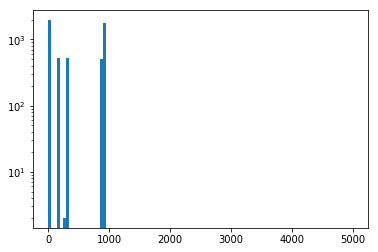

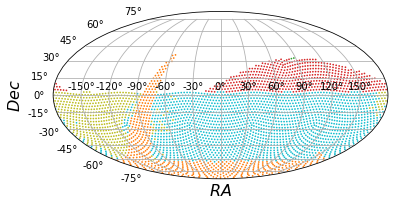

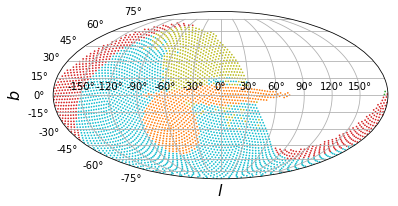

In [4]:
coords = SkyCoord(RA, Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree

f,ax = plt.subplots()
ax.hist(nobs,bins = 100, range=(0,5000))
ax.set_yscale('log', nonposy='clip')

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(nobs > 0)
ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 0.5, c=nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$l$",fontsize=16)
ax.set_ylabel(r"$b$",fontsize=16)
ax.scatter(lGal[xx]*np.pi/180.,bGal[xx]*np.pi/180., s = 0.5, c=nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)


### Get the TRILEGAL simulation at each OpSim field

*Just look at the first one for a test*

In [5]:
#this area is a bit odd because we're on a sphere... 
area = 10.
maglim = 24
sigma_AV = 0.1 #default
binaries = False
filterset = 'lsst' #kepler_2mass

for r,d,f in zip(RA,Dec,fID):
    print(r,d,f)
    filename = 'grid/trilegal.grid.id'+str(f)
    x = vespa.stars.trilegal.get_trilegal(filename, r, d, galactic=False, \
                                  filterset=filterset, area=area, maglim=maglim, binaries=binaries, \
                                  trilegal_version='1.6', sigma_AV=sigma_AV, convert_h5=True)
    
    break

0.0 -90.0 1.0


In [6]:
print(x)

None


In [21]:
filename = 'grid/trilegal.grid.id1.0.h5'
df = pd.read_hdf(filename)
dist = np.log10( 10.**(df['m-M0'].values/5.) *10. / 1000.) #log(d [kpc])
df['dist'] = dist
print(df)
#dist = 10.**(df['m-M0'].values/5.) * 10.# *u.parsec


        Gc  logAge  [M/H]     m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
0        1    6.65   0.27   0.51311 -1.374  3.592  4.837   7.2  0.347    0.0   
1        1    6.71  -0.19   0.13318 -1.740  3.509  4.285   8.0  0.458    0.0   
2        1    6.71  -0.09   0.74550 -0.736  3.671  4.676   8.2  0.371    0.0   
3        1    6.87  -0.07   1.62066  0.870  3.896  4.307   9.7  0.568    0.0   
4        1    6.87   0.07   0.74828 -0.767  3.661  4.668   8.8  0.431    0.0   
5        1    6.87   0.27   1.31862  0.403  3.806  4.326  12.8  0.432    0.0   
6        1    7.07   0.23   0.11043 -1.914  3.482  4.269   4.4  0.112    0.0   
7        1    7.15  -0.17   0.78918 -0.596  3.693  4.650   7.6  0.372    0.0   
8        1    7.15  -0.09   0.80570 -0.582  3.693  4.642  10.3  0.457    0.0   
9        1    7.17   0.13  14.01946  4.484  4.395  3.626   9.3  0.483    0.0   
10       1    7.21   0.17   0.22026 -2.181  3.536  5.052   7.1  0.346    0.0   
11       1    7.25   0.01   0.35666 -1.7

*Check some plots*

103604


Text(0.5,0,'Av')

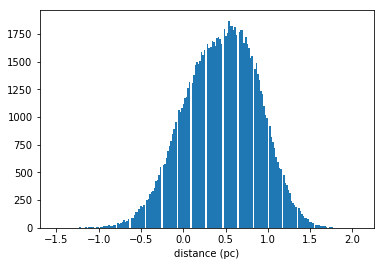

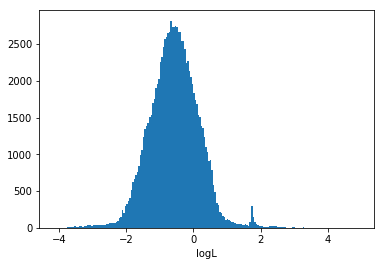

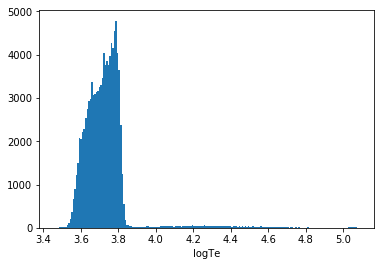

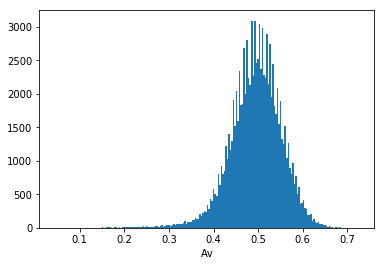

In [22]:
print(len(dist))
nbins = 200

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['dist'].values, bins=nbins)
ax.set_xlabel('distance (pc)')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logL'].values, bins=nbins)
ax.set_xlabel('logL')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logTe'].values, bins=nbins)
ax.set_xlabel('logTe')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['Av'].values, bins=nbins)
ax.set_xlabel('Av')

### Now draw some binaries from Katie Breivik's model

In [18]:
g = BreivikGalaxy()

#define the correct paths to the input files and db
g.GalaxyFile ='/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/dat_ThinDisk_12_0_12_0.h5' #for Katie's model
g.GalaxyFileLogPrefix ='/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/fixedPopLogCm_'

g.getKernel()

The number of binaries in the Gx for: 0012 is: 22919080853
both bright stars and eccentric


*This is how to draw stars from Katie's model*

In [27]:
nSample = 1
BreivikBin = g.GxSample(nSample)
EB = EclipsingBinary()
BreivikBin['Teff1'] = EB.getTeff(BreivikBin['Lum1'].values[0], BreivikBin['rad1'].values[0])
BreivikBin['Teff2'] = EB.getTeff(BreivikBin['Lum2'].values[0], BreivikBin['rad2'].values[0])
print(BreivikBin)


         m1        m2      porb       ecc      rad1      rad2      Lum1  \
0  0.415255  0.279767  3.885186  0.499451  1.409163  0.484932  0.477477   

      Lum2         xGX          yGX         zGX  dist_kpc       inc     OMEGA  \
0  0.03334 -940.165979 -1235.665045  228.724416  9.027455  0.061756  1.644622   

      omega        Teff1        Teff2  
0  1.776924  4048.158619  3547.313366  
